# Distanciamento Social
### Tarea 1 de Computación Gráfica - INF658
Este programa analiza un video captado por una cámara en la calle e identifica a las personas que no cumplen con el distanciamiento social.

***

**Realizado por:** [Alain M. Alejo Huarachi](//dealain.com)

**Profesor:** [Dr. Iván Sipirán Mendoza](//ivan-sipiran.com)

***

**Resultado:**

[![RESULTADO](https://img.youtube.com/vi/PPMXI7OtAig/1.jpg)](https://www.youtube.com/watch?v=PPMXI7OtAig)

**Código fuente:** https://github.com/alainno/birdeye

## 1. Pasos previos

* Descargamos la data (video y boundingboxes).

In [1]:
#!mkdir data
#!wget "http://www.robots.ox.ac.uk/ActiveVision/Research/Projects/2009bbenfold_headpose/Datasets/TownCentreXVID.avi" -P data/
#!wget "http://www.robots.ox.ac.uk/ActiveVision/Research/Projects/2009bbenfold_headpose/Datasets/TownCentre-groundtruth.top" -P data/

* Importamos librerías y definimos constantes.

In [2]:
import cv2
import numpy as np
from funciones import *
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import animation, rc
import matplotlib
from IPython.display import HTML
%matplotlib inline
matplotlib.rcParams['animation.embed_limit'] = 2**128

PATH_VIDEO = "data/TownCentreXVID.avi"
PATH_DATA = "data/TownCentre-groundtruth.top"

* Mostramos la primera imágen del video.

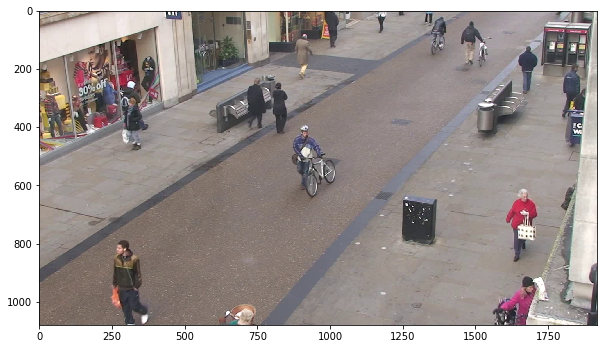

In [3]:
# Solo necesitamos la primera imágen del video
capture = cv2.VideoCapture(PATH_VIDEO)
if(capture.isOpened()):
    ret, first_image = capture.read()
    if ret == False:
        raise Exception("Error al obtener captura.")
else:
    raise Exception("Error al abrir video.")

capture.release()
#cv2.destroyAllWindows()
first_image = cv2.cvtColor(first_image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10,10))
plt.imshow(first_image)
plt.show()

* Seleccionamos un rectángulo para la transformación.

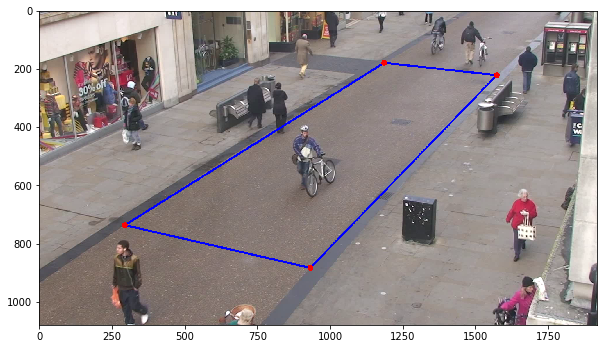

In [4]:
# Se seleccionan 4 puntos en la vista de perspectiva para mapearlos en un rectágulo de la vista birdview.
perspective_points = np.float32([[1187, 178], [1575, 220], [933,883], [295, 736]])

first_image_rectangle = first_image.copy()

pts = perspective_points.reshape((-1,1,2))
cv2.polylines(first_image_rectangle, [pts.astype(np.int32)], True, (0,0,255), thickness=5)

for i in range(0, 4):
    cv2.circle(first_image_rectangle, tuple(perspective_points[i]), 10, (255,0,0), -1)

plt.figure(figsize=(10,10))
plt.imshow(first_image_rectangle)
plt.show()

* Transformación de vista de cámara (perpectiva) a vista aérea plana (birdeye).

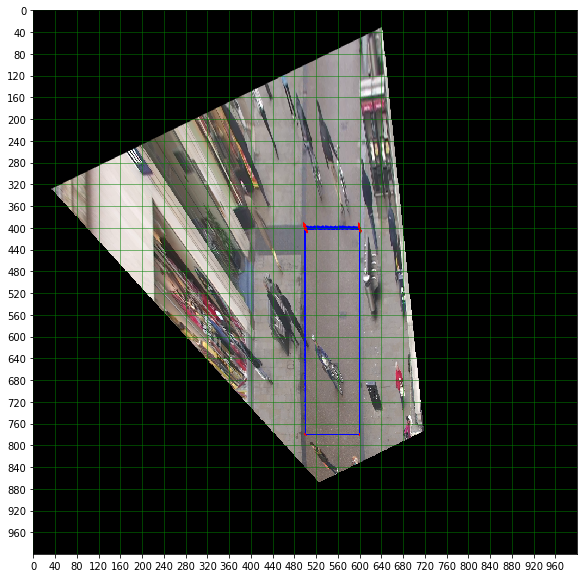

In [5]:
# Tamaño de la birdview destino
birdv_width = 1000
birdv_height = 1000

# Punto de inicio del rectángulo en la birdview
x_offset = 500
y_offset = 400

# Medidas proporcionales del ancho y largo del rectángulo
m_prop = 20 # 1m = 20px aprox.
rect_prop_width = 5*m_prop # propocional a 5m aprox.
rect_prop_height = 19*m_prop # proporcional a 19m aprox.

# Definimos los puntos del rectángulo en la birview
target = np.float32([[x_offset,y_offset],
                     [x_offset+rect_prop_width,y_offset],
                     [x_offset+rect_prop_width,y_offset+rect_prop_height],
                     [x_offset,y_offset+rect_prop_height]])

# Obtenemos la matriz de transformacion y estampamos la imagen del video en la birdview
matrix = cv2.getPerspectiveTransform(perspective_points, target)
first_image_birdv = cv2.warpPerspective(first_image_rectangle, matrix, (birdv_width,birdv_height))

# Se muestra el resultado
plt.figure(figsize=(10,10))
plt.imshow(first_image_birdv)
plt.xticks(np.arange(0, first_image_birdv.shape[1], step=m_prop*2))
plt.yticks(np.arange(0, first_image_birdv.shape[0], step=m_prop*2))
plt.grid(True, color='g', linestyle='-', linewidth=0.5)
plt.show()

## 2. Procesamiento del video

* Aperturamos la data de boundingboxes.

In [6]:
# Abrimos la data y asociamos headers
data = pd.read_csv(PATH_DATA)
data.columns = ['numPersona','numFrame','headValid','bodyValid','headLeft','headTop','headRight','headBottom','bodyLeft','bodyTop','bodyRight','bodyBottom']
data.tail()

,numPersona,numFrame,headValid,bodyValid,headLeft,headTop,headRight,headBottom,bodyLeft,bodyTop,bodyRight,bodyBottom
71454,226,4500,1,1,510.788,242.550,530.953,264.507,490.273,231.738,562.261,419.373
71455,227,4500,1,1,1596.158,522.755,1625.587,554.594,1555.319,506.651,1653.329,771.720
71456,228,4500,1,1,1173.783,534.921,1203.478,567.389,1144.991,518.861,1230.505,787.830
71457,229,4500,1,1,657.255,285.702,678.682,309.279,635.779,274.009,708.906,475.278
71458,230,4500,1,1,1383.071,137.226,1400.721,156.358,1362.262,128.042,1418.662,291.685


* Ahora procesamos la data en el video para obtener el distanciamiento social.

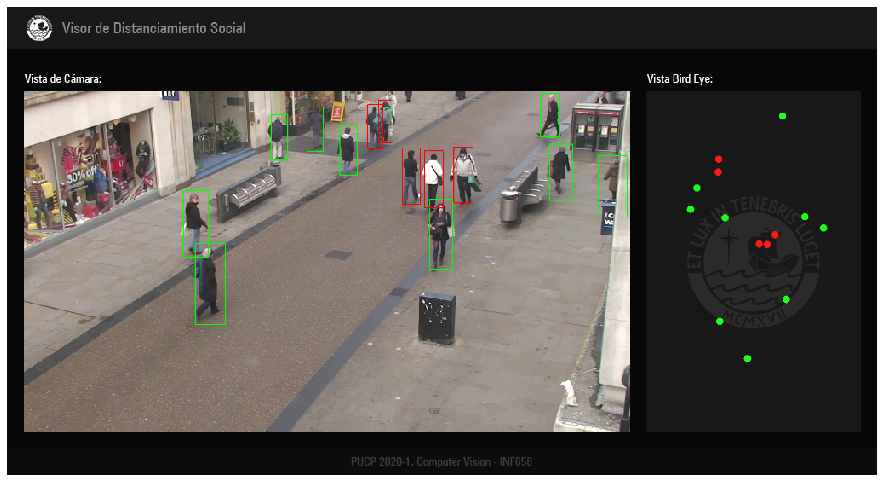

In [7]:
# Definimos constantes
MIN_DISTANCE_PROP =  30 # 1.5m aprox.
START_FRAME = 2000
STOP_FRAME = 2050
CAMERA_VIEW_SIZE = (712,400)
BIRD_VIEW_SIZE = (250,400)
BACKGROUND_IMAGE = 'frameview.png'

# Aperturamos video
video_capture = cv2.VideoCapture(PATH_VIDEO)

video_fps = video_capture.get(cv2.CAP_PROP_FPS)

plot_images = []
fig = plt.figure(figsize=(16,8.61))
plt.axis('off')

i = 0
while(video_capture.isOpened() and i < STOP_FRAME):
    ret, frame = video_capture.read()
    if ret == False:
        break
    
    if(i>=START_FRAME):
        # Obtenemos solo la data del frame actual
        frame_data = data[data['numFrame']==i]
        # Obtenemos el punto medio de la base (bottom) del boundingbox para cada persona
        frame_points = getFramePoints(frame_data)
        # Convertimos los puntos en perpectiva a puntos en birdview con la matriz de transformacion
        birdv_points = framePointsToBirdPoints(frame_points, matrix)
        # Identificamos el distanciamiento social a escala en la birdview
        birdv_points_colors, colors = pointsColorByDistance(birdv_points, MIN_DISTANCE_PROP)
        # Dibujamos los boundingboxes en la vista en perspectiva y generamos la imagen
        camera_image = drawBoundingBoxes(frame, frame_data, birdv_points, birdv_points_colors, colors, CAMERA_VIEW_SIZE)
        # Generamos la imagen para la birdview
        birdv_image = getBirdView(birdv_points_colors, colors, BIRD_VIEW_SIZE)
        # Integramos las imágenes en una sola
        integrated_image = getIntegratedView(BACKGROUND_IMAGE, camera_image, birdv_image)
        # Ploteamos la imágen final
        plot_image = plt.imshow(cv2.cvtColor(integrated_image, cv2.COLOR_BGR2RGB))
        plot_images.append([plot_image])
    
    i+=1

video_capture.release()
#cv2.destroyAllWindows()

* Mostramos el resultado animado.

In [ ]:
ani = animation.ArtistAnimation(fig, plot_images, interval=1000/video_fps, blit=True,
                                repeat_delay=1000)
rc('animation', html='jshtml')
ani

* Guardamos el resultado.

In [10]:
Writer = animation.writers['ffmpeg']
writer = Writer(fps=video_fps, metadata=dict(artist='Alain'), bitrate=1800)
ani.save('resultado.mp4', writer=writer)